In [3]:
import pandas as pd
import numpy as np
import re
import pickle
import os
from collections import Counter

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn imported successfully")


✓ All libraries imported successfully!
Pandas version: 2.3.1
Scikit-learn imported successfully


[nltk_data] Downloading package punkt to
[nltk_data]     /home/uzwalpandey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/uzwalpandey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/uzwalpandey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/uzwalpandey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/uzwalpandey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
print("Downloading NLTK resources...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("✓ NLTK resources downloaded successfully!")

✓ NLTK resources downloaded successfully!


In [5]:
print("=" * 70)
print("[STEP 1] LOADING ENRON EMAIL DATASET")
print("=" * 70)

# ========== UPDATE THIS PATH TO YOUR ENRON DATASET ==========
file_path = "emails.csv"  # <-- CHANGE THIS TO YOUR FILE LOCATION
# ============================================================

print(f"\nReading from: {file_path}")

# Check if file exists
if not os.path.exists(file_path):
    print(f"\n❌ ERROR: File not found at '{file_path}'")
    print("\nPlease:")
    print("1. Download from: https://www.kaggle.com/datasets/wcukierski/enron-email-dataset")
    print("2. Extract 'emails.csv'")
    print("3. Update the file_path in this cell")
else:
    print("✓ File found! Loading data (this may take 30-60 seconds for large files)...")
    
    # Load CSV
    df = pd.read_csv(file_path)
    print(f"✓ CSV loaded successfully!")
    
    print(f"\nDataset Info:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {df.columns.tolist()}")
    
    # Find email text column
    possible_columns = ['message', 'email', 'text', 'content', 'body', 'raw_content']
    email_column = None
    
    for col in possible_columns:
        if col in df.columns:
            email_column = col
            print(f"  ✓ Found email text in column: '{email_column}'")
            break
    
    if email_column is None:
        raise ValueError(f"Could not find email text column. Available: {df.columns.tolist()}")
    
    # Create standardized DataFrame
    df_emails = pd.DataFrame({'email_text': df[email_column]})
    print(f"\n✓ Created DataFrame with {len(df_emails)} emails")
    
    # Clean data
    print("\nCleaning data...")
    initial_count = len(df_emails)
    df_emails = df_emails.dropna()
    df_emails = df_emails[df_emails['email_text'].str.strip() != '']
    df_emails = df_emails.reset_index(drop=True)
    
    removed = initial_count - len(df_emails)
    if removed > 0:
        print(f"  Removed {removed} empty/null emails")
    
    print(f"\n✓ Final dataset: {len(df_emails)} emails ready for processing")
    
    # Show sample
    print("\n" + "=" * 70)
    print("SAMPLE EMAIL (First 300 characters):")
    print("=" * 70)
    sample_text = str(df_emails['email_text'].iloc[0])[:300]
    print(sample_text + "...")
    print("=" * 70)
    
    # Show dataset info
    print(f"\nDataset loaded: {len(df_emails)} emails")
    print(f"Memory usage: {df_emails.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


[STEP 1] LOADING ENRON EMAIL DATASET

Reading from: emails.csv
✓ File found! Loading data (this may take 30-60 seconds for large files)...
✓ CSV loaded successfully!

Dataset Info:
  Shape: (517401, 2)
  Columns: ['file', 'message']
  ✓ Found email text in column: 'message'

✓ Created DataFrame with 517401 emails

Cleaning data...

✓ Final dataset: 517401 emails ready for processing

SAMPLE EMAIL (First 300 characters):
Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden...

Dataset loaded: 517401 emails
Memory usage: 1366.67 MB


In [8]:

print(df.head())


                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [11]:
print("=" * 70)
print("DEFINING PREPROCESSING FUNCTIONS")
print("=" * 70)

class EmailPreprocessor:
    """Handles email preprocessing: lowercase, remove punctuation/numbers, tokenize, remove stopwords, lemmatize"""
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        print(f"✓ Preprocessor initialized")
        print(f"  Stopwords loaded: {len(self.stop_words)} words")
    
    def preprocess(self, text):
        if not isinstance(text, str):
            return ""
        
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        
        processed_tokens = [
            self.lemmatizer.lemmatize(token) 
            for token in tokens 
            if token not in self.stop_words and len(token) > 2
        ]
        
        return ' '.join(processed_tokens)

preprocessor = EmailPreprocessor()

# Test preprocessing on sample
print("\n" + "=" * 70)
print("PREPROCESSING TEST:")
print("=" * 70)
sample_email = df_emails['email_text'].iloc[0][:200]
print(f"\nOriginal: {sample_email}...")
print(f"\nProcessed: {preprocessor.preprocess(sample_email)}...")
print("\n✓ Preprocessing function working correctly!")

DEFINING PREPROCESSING FUNCTIONS
✓ Preprocessor initialized
  Stopwords loaded: 198 words

PREPROCESSING TEST:

Original: Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: t...

Processed: messageid javamailevansthyme date mon may pdt phillipallenenroncom timbeldenenroncom subject mimeversion contenttype...

✓ Preprocessing function working correctly!


In [13]:
print("=" * 70)
print("[STEP 2] PREPROCESSING ALL EMAILS")
print("=" * 70)
print("\nApplying preprocessing to all emails...")
print("Steps: Lowercasing → Remove punctuation/numbers → Tokenize → Remove stopwords → Lemmatize")

# Process all emails with progress indicator
from tqdm import tqdm
tqdm.pandas(desc="Processing emails")

df_emails['processed_text'] = df_emails['email_text'].progress_apply(preprocessor.preprocess)

print(f"\n✓ Preprocessed {len(df_emails)} emails successfully!")

# Show before/after examples
print("\n" + "=" * 70)
print("BEFORE/AFTER EXAMPLES:")
print("=" * 70)
for i in range(3):
    print(f"\n--- Email {i+1} ---")
    print(f"Original: {df_emails['email_text'].iloc[i][:150]}...")
    print(f"Processed: {df_emails['processed_text'].iloc[i][:150]}...")


[STEP 2] PREPROCESSING ALL EMAILS

Applying preprocessing to all emails...
Steps: Lowercasing → Remove punctuation/numbers → Tokenize → Remove stopwords → Lemmatize


Processing emails: 100%|█████████████| 517401/517401 [07:32<00:00, 1144.23it/s]


✓ Preprocessed 517401 emails successfully!

BEFORE/AFTER EXAMPLES:

--- Email 1 ---
Original: Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enr...
Processed: messageid javamailevansthyme date mon may pdt phillipallenenroncom timbeldenenroncom subject mimeversion contenttype textplain charsetusascii contentt...

--- Email 2 ---
Original: Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>
Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)
From: phillip.allen@enron.com
To: john.lavorato@e...
Processed: messageid javamailevansthyme date fri may pdt phillipallenenroncom johnlavoratoenroncom subject mimeversion contenttype textplain charsetusascii conte...

--- Email 3 ---
Original: Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>
Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)
From: phillip.allen@enron.com
To: leah.arsdall@e...
Processed: messageid javamailevansthyme date wed oct pdt ph

In [15]:
print("=" * 70)
print("DEFINING AUTO-LABELING KEYWORDS")
print("=" * 70)

CATEGORY_KEYWORDS = {
    'HR': [
        'hiring', 'recruitment', 'recruit', 'interview', 'interviewing', 'vacancy', 
        'vacancies', 'salary', 'salaries', 'leave', 'holiday', 'vacation', 
        'attendance', 'absent', 'benefits', 'benefit', 'policy', 'policies', 
        'employee', 'employees', 'staff', 'personnel', 'onboarding', 'offboarding',
        'resignation', 'termination', 'performance', 'appraisal', 'hr', 'human resource'
    ],
    'Financial': [
        'invoice', 'invoices', 'payment', 'payments', 'pay', 'bill', 'billing',
        'budget', 'budgets', 'revenue', 'revenues', 'profit', 'profits', 'loss',
        'salary', 'salaries', 'audit', 'auditing', 'finance', 'financial',
        'contract', 'contracts', 'fund', 'funds', 'funding', 'expense', 'expenses',
        'cost', 'costs', 'accounting', 'transaction', 'fiscal', 'quarterly',
        'revenue', 'expenditure', 'vendor', 'procurement'
    ],
    'Urgent': [
        'urgent', 'urgently', 'immediately', 'immediate', 'asap', 'important',
        'action required', 'emergency', 'emergencies', 'critical', 'crucial',
        'priority', 'deadline', 'time sensitive', 'alert', 'warning', 'attention',
        'must', 'required', 'need', 'now', 'today', 'tonight'
    ],
    'General': []
}

print("✓ Keywords defined for 4 categories:")
for category, keywords in CATEGORY_KEYWORDS.items():
    print(f"  {category}: {len(keywords)} keywords")

print("\nLabeling Priority: Urgent > HR > Financial > General")

DEFINING AUTO-LABELING KEYWORDS
✓ Keywords defined for 4 categories:
  HR: 30 keywords
  Financial: 37 keywords
  Urgent: 23 keywords
  General: 0 keywords

Labeling Priority: Urgent > HR > Financial > General


[STEP 3] AUTO-LABELING EMAILS
Labeling emails...

✓ Labeled 517401 emails

CATEGORY DISTRIBUTION:
  Urgent      : 288698 emails (55.80%)
  General     : 106731 emails (20.63%)
  HR          :  89208 emails (17.24%)
  Financial   :  32764 emails ( 6.33%)


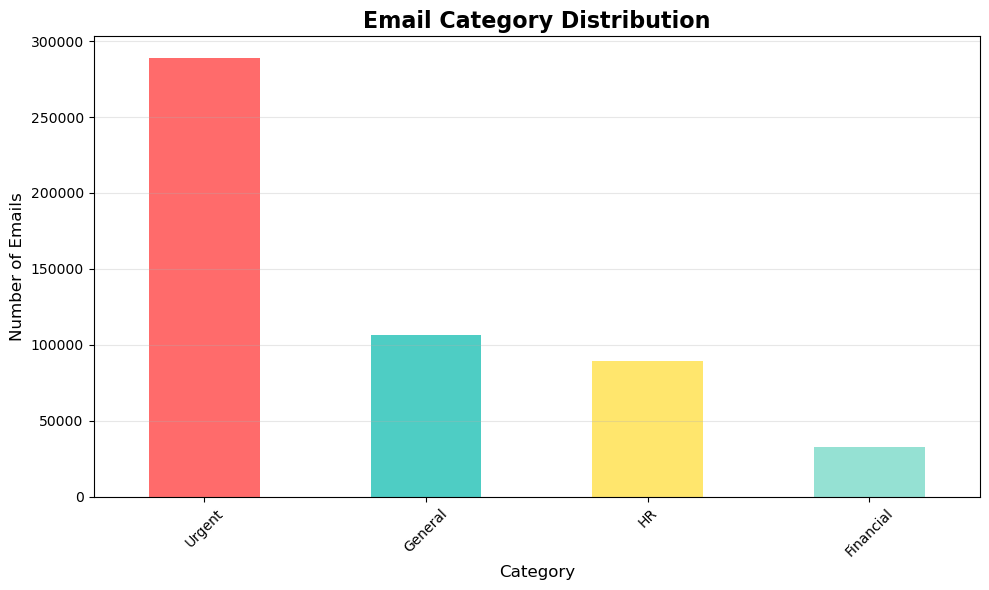


SAMPLE EMAILS BY CATEGORY:

General:
  Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enr...

Urgent:
  Message-ID: <13505866.1075863688222.JavaMail.evans@thyme>
Date: Mon, 23 Oct 2000 06:13:00 -0700 (PDT)
From: phillip.allen@enron.com
To: randall.gay@en...

Financial:
  Message-ID: <26575732.1075855687756.JavaMail.evans@thyme>
Date: Mon, 2 Oct 2000 02:19:00 -0700 (PDT)
From: phillip.allen@enron.com
To: bs_stone@yahoo....

HR:
  Message-ID: <15294346.1075855687778.JavaMail.evans@thyme>
Date: Thu, 28 Sep 2000 06:17:00 -0700 (PDT)
From: phillip.allen@enron.com
To: lkuch@mh.com
S...


In [17]:
print("=" * 70)
print("[STEP 3] AUTO-LABELING EMAILS")
print("=" * 70)

def auto_label_email(processed_text):
    """Label email based on keyword matching"""
    text_lower = processed_text.lower()
    
    if any(keyword in text_lower for keyword in CATEGORY_KEYWORDS['Urgent']):
        return 'Urgent'
    if any(keyword in text_lower for keyword in CATEGORY_KEYWORDS['HR']):
        return 'HR'
    if any(keyword in text_lower for keyword in CATEGORY_KEYWORDS['Financial']):
        return 'Financial'
    return 'General'

print("Labeling emails...")
df_emails['category'] = df_emails['processed_text'].apply(auto_label_email)

print(f"\n✓ Labeled {len(df_emails)} emails")

# Show category distribution
print("\n" + "=" * 70)
print("CATEGORY DISTRIBUTION:")
print("=" * 70)
category_counts = df_emails['category'].value_counts()
for category, count in category_counts.items():
    percentage = (count / len(df_emails)) * 100
    print(f"  {category:12s}: {count:6d} emails ({percentage:5.2f}%)")

# Visualize distribution
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#FFE66D', '#95E1D3'])
plt.title('Email Category Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Emails', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Show examples from each category
print("\n" + "=" * 70)
print("SAMPLE EMAILS BY CATEGORY:")
print("=" * 70)
for category in df_emails['category'].unique():
    sample = df_emails[df_emails['category'] == category]['email_text'].iloc[0]
    print(f"\n{category}:")
    print(f"  {sample[:150]}...")

In [19]:
print("=" * 70)
print("[STEP 4] TF-IDF VECTORIZATION")
print("=" * 70)

print("Creating TF-IDF vectorizer...")
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

print("Transforming text to TF-IDF features...")
X = tfidf.fit_transform(df_emails['processed_text'])
y = df_emails['category']

print(f"\n✓ TF-IDF Vectorization Complete!")
print(f"  Matrix shape: {X.shape}")
print(f"  Features (vocabulary): {len(tfidf.vocabulary_)} terms")
print(f"  Sparsity: {(1.0 - X.nnz / (X.shape[0] * X.shape[1])) * 100:.2f}%")

# Show top features
print("\n" + "=" * 70)
print("TOP 20 TF-IDF FEATURES:")
print("=" * 70)
feature_names = tfidf.get_feature_names_out()
print(", ".join(feature_names[:20]))


[STEP 4] TF-IDF VECTORIZATION
Creating TF-IDF vectorizer...
Transforming text to TF-IDF features...

✓ TF-IDF Vectorization Complete!
  Matrix shape: (517401, 5000)
  Features (vocabulary): 5000 terms
  Sparsity: 98.09%

TOP 20 TF-IDF FEATURES:
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa, aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa, aaron, abb, ability, able, absence, absolutely, accept, acceptable, acceptance, acceptance create, accepted, access, accordance, according, accordingly, account, accounting, accurate


In [21]:
print("=" * 70)
print("[STEP 5] TRAIN/TEST SPLIT")
print("=" * 70)

print("Splitting data (80% train, 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Data Split Complete!")
print(f"  Training set: {X_train.shape[0]:,} samples ({(X_train.shape[0]/len(df_emails)*100):.1f}%)")
print(f"  Test set: {X_test.shape[0]:,} samples ({(X_test.shape[0]/len(df_emails)*100):.1f}%)")

print("\n" + "=" * 70)
print("TRAINING SET DISTRIBUTION:")
print("=" * 70)
train_dist = pd.Series(y_train).value_counts()
for category, count in train_dist.items():
    print(f"  {category:12s}: {count:6d} emails")

print("\n" + "=" * 70)
print("TEST SET DISTRIBUTION:")
print("=" * 70)
test_dist = pd.Series(y_test).value_counts()
for category, count in test_dist.items():
    print(f"  {category:12s}: {count:6d} emails")


[STEP 5] TRAIN/TEST SPLIT
Splitting data (80% train, 20% test)...

✓ Data Split Complete!
  Training set: 413,920 samples (80.0%)
  Test set: 103,481 samples (20.0%)

TRAINING SET DISTRIBUTION:
  Urgent      : 230958 emails
  General     :  85385 emails
  HR          :  71366 emails
  Financial   :  26211 emails

TEST SET DISTRIBUTION:
  Urgent      :  57740 emails
  General     :  21346 emails
  HR          :  17842 emails
  Financial   :   6553 emails


In [23]:
print("=" * 70)
print("[STEP 6] TRAINING LOGISTIC REGRESSION MODEL")
print("=" * 70)

print("Initializing model...")
model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    C=1.0
)

print("Training model (this may take 1-2 minutes)...")
model.fit(X_train, y_train)

print("\n✓ Model Training Complete!")
print(f"  Algorithm: Logistic Regression")
print(f"  Classes: {model.classes_}")
print(f"  Iterations: {model.n_iter_[0]}")


[STEP 6] TRAINING LOGISTIC REGRESSION MODEL
Initializing model...
Training model (this may take 1-2 minutes)...

✓ Model Training Complete!
  Algorithm: Logistic Regression
  Classes: ['Financial' 'General' 'HR' 'Urgent']
  Iterations: 210


[STEP 7] MODEL EVALUATION
Making predictions on test set...

ACCURACY: 0.9397 (93.97%)

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   Financial       0.77      0.92      0.84      6553
     General       0.90      0.98      0.93     21346
          HR       0.90      0.89      0.90     17842
      Urgent       1.00      0.94      0.97     57740

    accuracy                           0.94    103481
   macro avg       0.89      0.93      0.91    103481
weighted avg       0.94      0.94      0.94    103481


CONFUSION MATRIX:
✓ Confusion matrix saved as 'confusion_matrix.png'


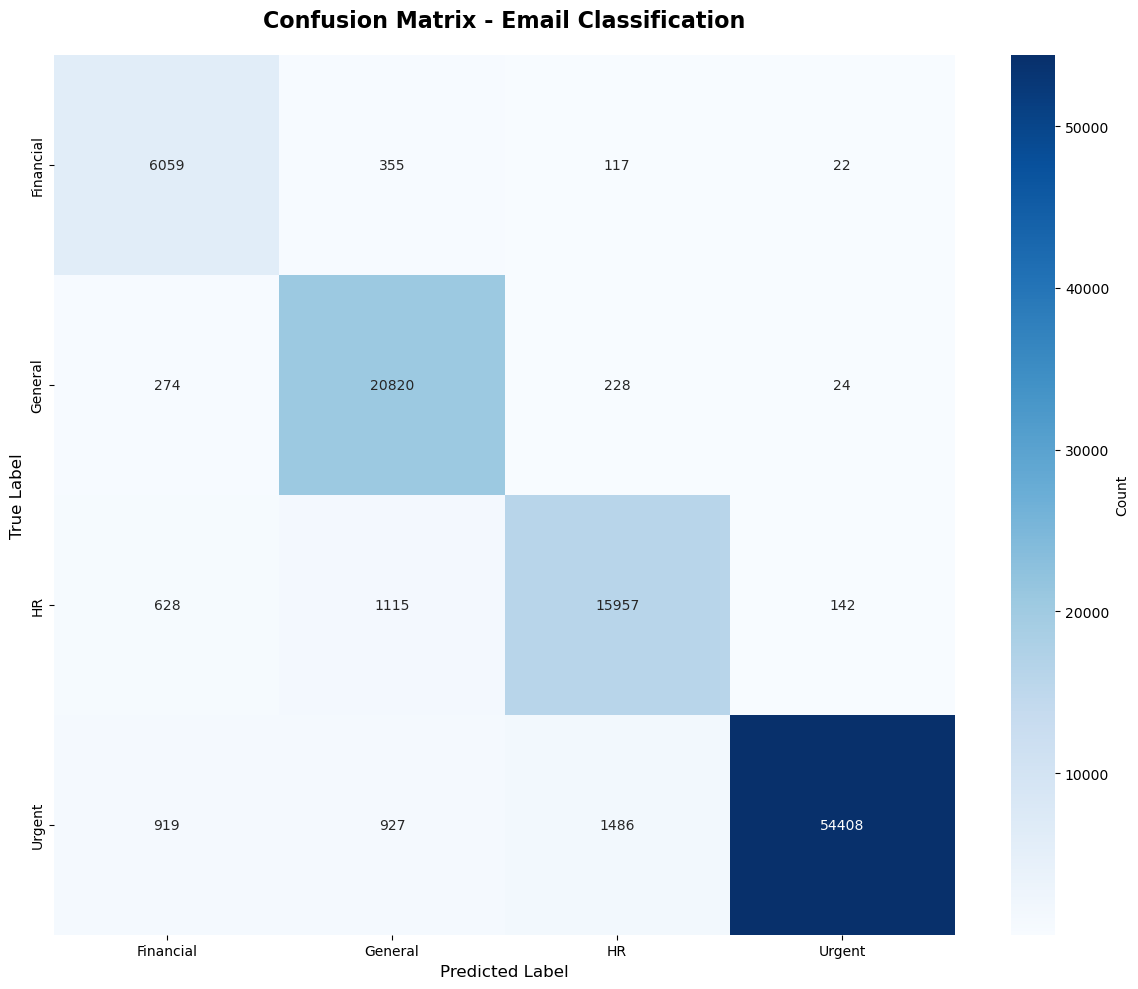


PER-CATEGORY PERFORMANCE:
  Financial   : 0.9246 (92.46%)
  General     : 0.9754 (97.54%)
  HR          : 0.8944 (89.44%)
  Urgent      : 0.9423 (94.23%)


In [25]:
print("=" * 70)
print("[STEP 7] MODEL EVALUATION")
print("=" * 70)

print("Making predictions on test set...")
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n{'='*70}")
print(f"ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"{'='*70}")

# Classification report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT:")
print("=" * 70)
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\n" + "=" * 70)
print("CONFUSION MATRIX:")
print("=" * 70)
cm = confusion_matrix(y_test, y_pred)
categories = sorted(model.classes_)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Email Classification', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Per-category metrics
print("\n" + "=" * 70)
print("PER-CATEGORY PERFORMANCE:")
print("=" * 70)
for i, category in enumerate(categories):
    category_mask = y_test == category
    category_accuracy = accuracy_score(y_test[category_mask], y_pred[category_mask])
    print(f"  {category:12s}: {category_accuracy:.4f} ({category_accuracy*100:.2f}%)")


In [27]:
# ==================== CELL 12: SAVE MODEL ====================
print("=" * 70)
print("[STEP 8] SAVING MODEL AND VECTORIZER")
print("=" * 70)

print("Saving model to 'model.pkl'...")
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✓ Model saved!")

print("\nSaving TF-IDF vectorizer to 'tfidf.pkl'...")
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("✓ Vectorizer saved!")

# Verify files
model_size = os.path.getsize('model.pkl') / 1024
tfidf_size = os.path.getsize('tfidf.pkl') / 1024
print(f"\n✓ Files created successfully:")
print(f"  model.pkl: {model_size:.2f} KB")
print(f"  tfidf.pkl: {tfidf_size:.2f} KB")


[STEP 8] SAVING MODEL AND VECTORIZER
Saving model to 'model.pkl'...
✓ Model saved!

Saving TF-IDF vectorizer to 'tfidf.pkl'...
✓ Vectorizer saved!

✓ Files created successfully:
  model.pkl: 157.02 KB
  tfidf.pkl: 193.02 KB


In [29]:
# ==================== CELL 13: DEFINE PREDICTION FUNCTION ====================
print("=" * 70)
print("[STEP 9] DEFINING PREDICTION FUNCTION")
print("=" * 70)

def predict_category(email_text):
    """
    Load saved model and predict category for new email
    Returns: (predicted_category, confidence_scores_dict)
    """
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    with open('tfidf.pkl', 'rb') as f:
        tfidf = pickle.load(f)
    
    # Preprocess
    preprocessor = EmailPreprocessor()
    processed_text = preprocessor.preprocess(email_text)
    
    # Transform and predict
    email_vector = tfidf.transform([processed_text])
    prediction = model.predict(email_vector)[0]
    probabilities = model.predict_proba(email_vector)[0]
    prob_dict = dict(zip(model.classes_, probabilities))
    
    return prediction, prob_dict

print("✓ Prediction function defined!")


[STEP 9] DEFINING PREDICTION FUNCTION
✓ Prediction function defined!


In [31]:
# ==================== CELL 14: TEST PREDICTIONS ====================
print("=" * 70)
print("TESTING PREDICTION FUNCTION")
print("=" * 70)

test_emails = [
    "We need to schedule interviews for the software engineer position next week.",
    "Please process the invoice payment of $25,000 by end of day today.",
    "URGENT: System down! Need immediate attention and action required!",
    "Team meeting scheduled for next Monday at 3 PM in conference room."
]

for i, email in enumerate(test_emails, 1):
    print(f"\n{'='*70}")
    print(f"TEST EMAIL {i}:")
    print(f"{'='*70}")
    print(f"Text: {email}")
    
    prediction, probabilities = predict_category(email)
    
    print(f"\nPredicted Category: ⭐ {prediction} ⭐")
    print("\nConfidence Scores:")
    for cat, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
        bar = '█' * int(prob * 50)
        print(f"  {cat:12s}: {prob:.4f} ({prob*100:5.2f}%) {bar}")


TESTING PREDICTION FUNCTION

TEST EMAIL 1:
Text: We need to schedule interviews for the software engineer position next week.
✓ Preprocessor initialized
  Stopwords loaded: 198 words

Predicted Category: ⭐ Urgent ⭐

Confidence Scores:
  Urgent      : 1.0000 (100.00%) █████████████████████████████████████████████████
  HR          : 0.0000 ( 0.00%) 
  Financial   : 0.0000 ( 0.00%) 
  General     : 0.0000 ( 0.00%) 

TEST EMAIL 2:
Text: Please process the invoice payment of $25,000 by end of day today.
✓ Preprocessor initialized
  Stopwords loaded: 198 words

Predicted Category: ⭐ Urgent ⭐

Confidence Scores:
  Urgent      : 1.0000 (100.00%) █████████████████████████████████████████████████
  Financial   : 0.0000 ( 0.00%) 
  HR          : 0.0000 ( 0.00%) 
  General     : 0.0000 ( 0.00%) 

TEST EMAIL 3:
Text: URGENT: System down! Need immediate attention and action required!
✓ Preprocessor initialized
  Stopwords loaded: 198 words

Predicted Category: ⭐ Urgent ⭐

Confidence Scores:
  Urgen

In [37]:
# ==================== CELL 15: INTERACTIVE PREDICTION ====================
print("=" * 70)
print("INTERACTIVE EMAIL CLASSIFICATION")
print("=" * 70)

print("\nType or paste any email content to classify it.")
print("Press ENTER when done.\n")

# Take email input from user
user_email = input("Enter your Gmail message here:\n\n> ")

print(f"\n{'='*70}")
print("YOUR EMAIL:")
print(f"{'='*70}")
print(user_email)

# Predict
prediction, probabilities = predict_category(user_email)

print(f"\nPredicted Category: ⭐ {prediction} ⭐")
print("\nConfidence Scores:")

for cat, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
    bar = '█' * int(prob * 50)
    print(f"  {cat:12s}: {prob:.4f} ({prob*100:5.2f}%) {bar}")


INTERACTIVE EMAIL CLASSIFICATION

Type or paste any email content to classify it.
Press ENTER when done.



Enter your Gmail message here:

>   We need to schedule interviews for the software engineer position next week. ✓ Preprocessor initialized



YOUR EMAIL:
 We need to schedule interviews for the software engineer position next week. ✓ Preprocessor initialized
✓ Preprocessor initialized
  Stopwords loaded: 198 words

Predicted Category: ⭐ Urgent ⭐

Confidence Scores:
  Urgent      : 1.0000 (100.00%) █████████████████████████████████████████████████
  HR          : 0.0000 ( 0.00%) 
  Financial   : 0.0000 ( 0.00%) 
  General     : 0.0000 ( 0.00%) 
